# Image classification with CNN
<br>Last updated on 21/01/2025</br>
Objective: We aim to classify images into 10 classes of cifar10 dataset using pytorch lighting.

credit : https://colab.research.google.com/github/pvateekul/2110531_DSDE_2024s1/blob/main/code/Week04_DL/1_Image_classification_CIFAR10_CNN.ipynb#scrollTo=wtpjzmgAz6Ru

In [ ]:
! nvidia-smi

Fri Feb  7 16:15:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Library

In [ ]:
from sklearn.exceptions import UndefinedMetricWarning


def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn

In [ ]:
%pip install pytorch-lightning
%pip install torchinfo
%pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 46.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import Accuracy
import torch.optim as optim
from pytorch_lightning.callbacks import ModelCheckpoint

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device-> cuda:{device's number}

print(device)

cuda:0


In [ ]:
transform = transforms.Compose(  # transform is from torchvision (only for image)
    [
        transforms.ToTensor(),  # image to tensor --> divide by 255
        transforms.Resize((32, 32)),
    ]
)

batch_size = 32

# Dataset

In [ ]:
torchvision.datasets

<module 'torchvision.datasets' from '/usr/local/lib/python3.11/dist-packages/torchvision/datasets/__init__.py'>

In [ ]:
trainvalset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainset, valset = torch.utils.data.random_split(trainvalset, [40000, 10000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


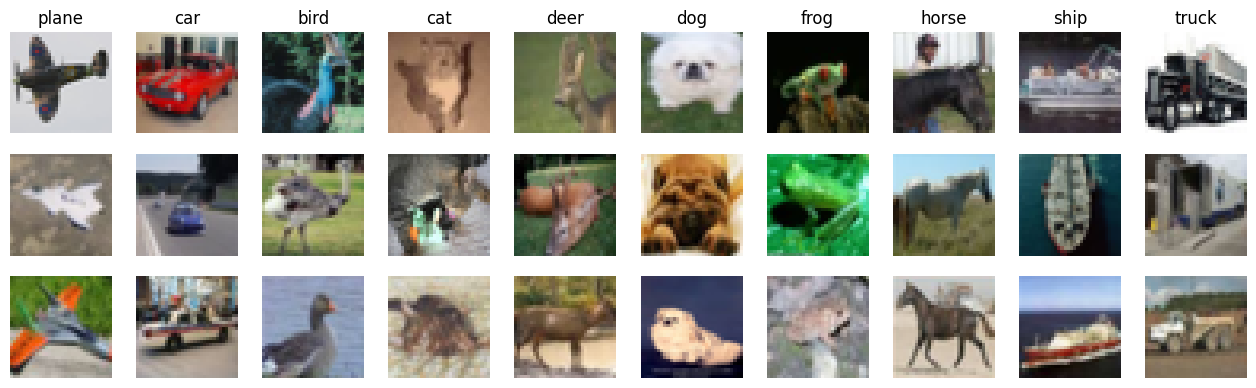

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def PlotRandomFromEachClass(X, Y, N, labels):
    C = np.unique(Y)
    M = len(C)
    plt.figure(figsize=(16, N * 1.5))
    for i in range(M):
        mask = np.squeeze(Y == C[i])
        indexes = np.random.choice(X.shape[0], N, replace=False, p=mask / sum(mask))
        for j in range(N):
            plt.subplot(N, M, j * M + i + 1)
            plt.imshow(X[indexes[j]], aspect="equal")
            plt.axis("off")
            if j == 0:
                plt.title(labels[i])


classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
PlotRandomFromEachClass(
    trainset.dataset.data, trainset.dataset.targets, 3, labels=classes
)

In [ ]:
trainset.__len__(), valset.__len__(), testset.__len__()

(40000, 10000, 10000)

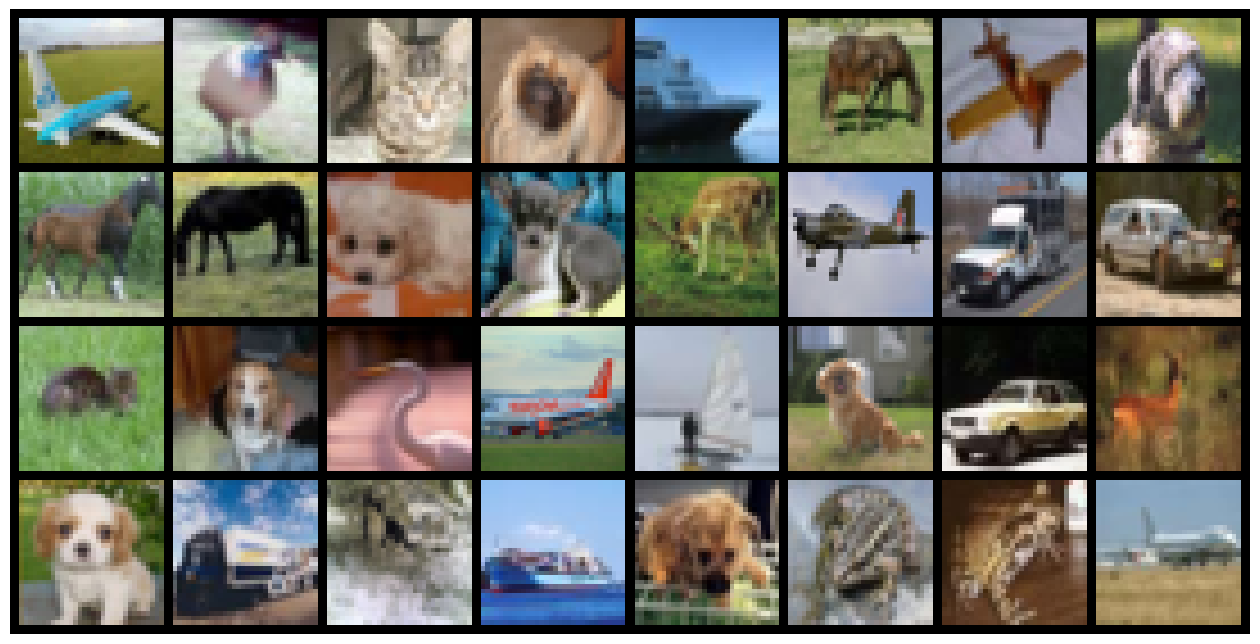

In [ ]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(16, 16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
nrow = 8
imshow(torchvision.utils.make_grid(images, nrow=nrow))

In [ ]:
# print labels
for i in range(batch_size // nrow + 1 if batch_size % nrow else batch_size // nrow):
    print(
        " ".join(
            f"{labels[i*nrow+j]:<3}" for j in range(min(batch_size - i * nrow, nrow))
        )
    )

0   2   3   5   8   7   0   5  
7   7   5   5   4   0   9   1  
3   5   2   0   8   5   1   4  
5   9   3   8   5   6   6   0  


# Model

In [ ]:
class CNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            3, 6, 5
        )  # 3 input channels, 6 output channels, 5*5 kernel size
        self.pool = nn.MaxPool2d(2, 2)  # 2*2 kernel size, 2 strides
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(400, 120)  # dense input 400 (16*5), output 120

        self.fc2 = nn.Linear(120, 84)  # dense input 120, output 84
        self.fc3 = nn.Linear(84, 10)  # dense input 84, output 10
        self.softmax = torch.nn.Softmax(
            dim=1
        )  # perform softmax at dim[1] (batch,class)

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=10)
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        self.train_metrics_epoch = []
        self.val_metrics_epoch = []
        self.n_ = 0

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(
            x, start_dim=1
        )  # flatten all dimensions (dim[1]) except batch (dim[0])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.train_loss.append(loss)
        self.train_acc.append(acc)

        # Log metrics
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        # Collect epoch metrics
        self.train_metrics_epoch.append(
            {
                "train_loss": sum(self.train_loss) / len(self.train_loss),
                "train_acc": sum(self.train_acc) / len(self.train_acc),
            }
        )
        self.train_loss = []
        self.train_acc = []

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(logits.softmax(dim=-1), y)
        self.val_loss.append(loss)
        self.val_acc.append(acc)

        # Log metrics
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self):
        # Update validation metrics
        self.val_metrics_epoch.append(
            {
                "val_loss": sum(self.val_loss) / len(self.val_loss),
                "val_acc": sum(self.val_acc) / len(self.val_acc),
            }
        )
        self.val_loss = []
        self.val_acc = []

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)


net = CNN().to(device)

In [ ]:
# from torchsummary import summary
# summary(net, (3, 100, 100), batch_size = 32)

from torchinfo import summary as summary_info

print(summary_info(net, input_size=(32, 3, 32, 32)))  # (batchsize,channel,width,height)
net = net.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [32, 10]                  --
├─Conv2d: 1-1                            [32, 6, 28, 28]           456
├─MaxPool2d: 1-2                         [32, 6, 14, 14]           --
├─Conv2d: 1-3                            [32, 16, 10, 10]          2,416
├─MaxPool2d: 1-4                         [32, 16, 5, 5]            --
├─Linear: 1-5                            [32, 120]                 48,120
├─Linear: 1-6                            [32, 84]                  10,164
├─Linear: 1-7                            [32, 10]                  850
├─Softmax: 1-8                           [32, 10]                  --
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 21.06
Input size (MB): 0.39
Forward/backward pass size (MB): 1.67
Params size (MB): 0.25
Estimated Total Size (MB): 2.31


In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",  # Monitor validation accuracy
    mode="max",  # Save the model with the highest accuracy
    save_top_k=1,  # Save only the best model
    filename="best-acc-{epoch:02d}-{val_acc:.4f}",  # File name format
    verbose=True,  # Print messages when saving
)

# Training

In [ ]:
trainer = pl.Trainer(max_epochs=1, callbacks=[checkpoint_callback])
trainer.fit(net, trainloader, valloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | conv1     | Conv2d             | 456    | train
1 | pool      | MaxPool2d          | 0      | train
2 | conv2     | Conv2d             | 2.4 K  | train
3 | fc1       | Linear             | 48.1 K | train
4 | fc2       | Linear             | 10.2 K | train
5 | fc3       | Linear             | 850    | train
6 | softmax   | Softmax            | 0      | train
7 | criterion | CrossEntropyLoss   | 0      | train
8 | accuracy  | MulticlassAccuracy | 0      | train
----------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1250: 'val_acc' reached 0.36670 (best 0.36670), saving model to '/content/lightning_logs/version_0/checkpoints/best-acc-epoch=00-val_acc=0.3667.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


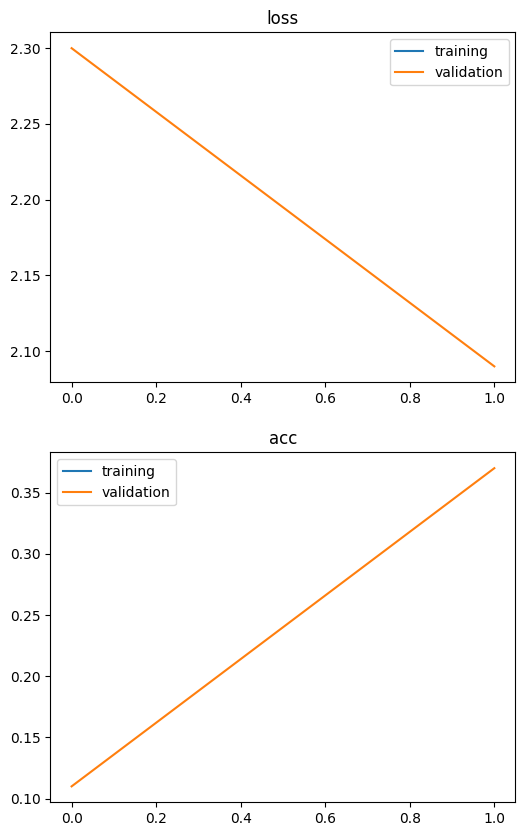

In [ ]:
fig, axs = plt.subplots(2, figsize=(6, 10))
# loss
axs[0].plot(
    [round(float(entry["train_loss"]), 2) for entry in net.train_metrics_epoch],
    label="training",
)
axs[0].plot(
    [round(float(entry["val_loss"]), 2) for entry in net.val_metrics_epoch],
    label="validation",
)
axs[0].set_title("loss")
axs[0].legend()
# acc
axs[1].plot(
    [round(float(entry["train_acc"]), 2) for entry in net.train_metrics_epoch],
    label="training",
)
axs[1].plot(
    [round(float(entry["val_acc"]), 2) for entry in net.val_metrics_epoch],
    label="validation",
)
axs[1].set_title("acc")
axs[1].legend()

In [ ]:
from typing import NewType

print(f"Best model saved at: {checkpoint_callback.best_model_path}")

best_model_path = checkpoint_callback.best_model_path
best_model = CNN.load_from_checkpoint(best_model_path).to(device)

# Use the best model for inference
best_model.eval()
best_model.freeze()

Best model saved at: /content/lightning_logs/version_0/checkpoints/best-acc-epoch=00-val_acc=0.3667.ckpt


# Evaluation & Inference

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
criterion = nn.CrossEntropyLoss()

print("testing ...")
y_predict = list()
y_labels = list()
test_loss = 0.0
n = 0
with torch.no_grad():
    for data in tqdm(testloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        y_labels += list(labels.cpu().numpy())
        y_predict += list(outputs.argmax(dim=1).cpu().numpy())
        n += 1

    # print statistics
    test_loss /= n
    print(f"testing loss: {test_loss:.4}")

    report = classification_report(y_labels, y_predict, digits=4)
    M = confusion_matrix(y_labels, y_predict)
    print(report)
    disp = ConfusionMatrixDisplay(confusion_matrix=M)

testing ...


  0%|          | 0/313 [00:00<?, ?it/s]

testing loss: 2.085
              precision    recall  f1-score   support

           0     0.5016    0.3180    0.3892      1000
           1     0.3963    0.5120    0.4468      1000
           2     0.2124    0.0410    0.0687      1000
           3     0.3000    0.0060    0.0118      1000
           4     0.3765    0.2180    0.2761      1000
           5     0.3403    0.3270    0.3335      1000
           6     0.3711    0.6680    0.4771      1000
           7     0.3908    0.4600    0.4226      1000
           8     0.4115    0.5230    0.4606      1000
           9     0.3097    0.6420    0.4178      1000

    accuracy                         0.3715     10000
   macro avg     0.3610    0.3715    0.3304     10000
weighted avg     0.3610    0.3715    0.3304     10000



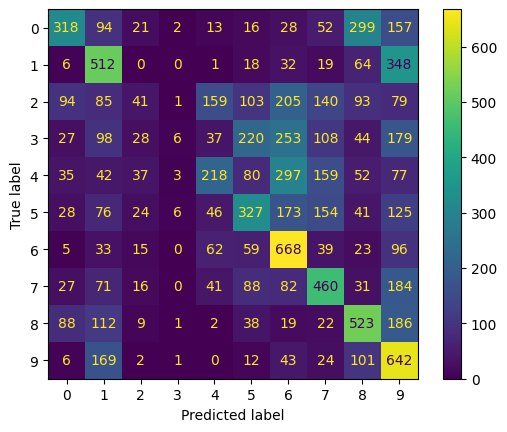

In [ ]:
disp.plot()
plt.show()

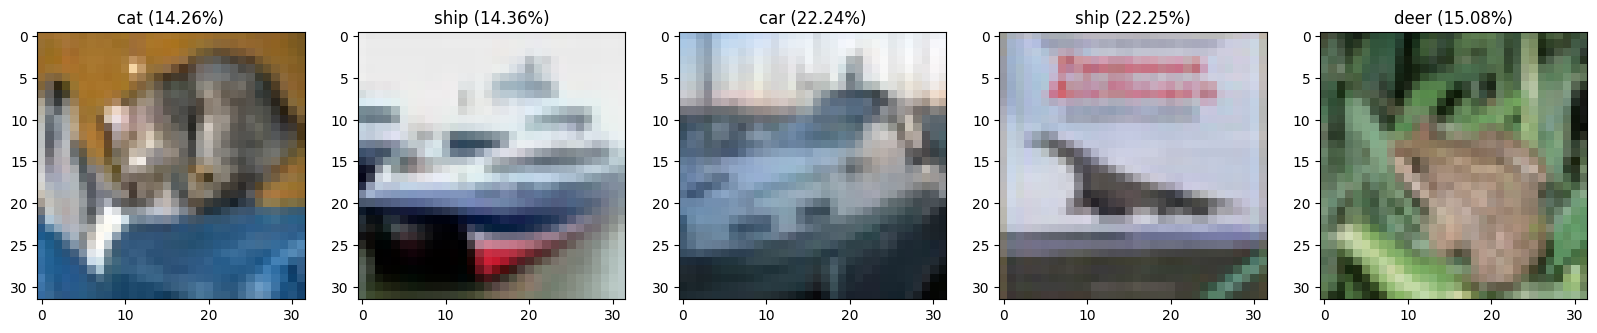

In [ ]:
plt.figure(figsize=(20, 5))
dataiter = iter(testloader)
inputs, labels = next(dataiter)
with torch.no_grad():
    best_model.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = best_model(inputs)
    loss = criterion(outputs, labels)
    test_loss += loss.item()

    y_labels = list(labels.cpu().numpy())
    y_predict = list(outputs.argmax(dim=1).cpu().numpy())
    # To get probabilities, you can run a softmax on outputs
    y_probs = torch.nn.functional.softmax(outputs, dim=1)
    y_probs = list(y_probs.cpu().numpy())

# We selected a sample from the first five images for visualization
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = inputs[i]  # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    most_prob = np.argmax(y_probs[i])
    label = classes[most_prob]
    prob = y_probs[i][most_prob]
    plt.title(f"{label} ({prob*100:.2f}%)")